# **課題1**

途中まで実験の過程です。下にスクロールして、「以下を実行」以降のセルをクリックしてください。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random

In [18]:
# - データの読み込み(dat1.txt, dat2.txt)
#   - 1行に1つのデータが入っている
#   - dat1とdat2の同時刻の(j行目の)データを縦に並べて、列ベクトルx_jに格納し、これを横に並べて行列Xを作る
#     - 列ベクトルの要素数は、2


f1 = open('data/dat1.txt')
f2 = open('data/dat2.txt')
X = []
while True:
    line1 = f1.readline()
    line2 = f2.readline()
    if not line1:
        break
    # print(line1, end='')
    # print(line2, end='')
    X.append([float(line1), float(line2)])
X = np.array(X) 
# X = X.T
# type(X)
# datanum, datasize = X.shape
# datasizeは時系列の数、datanumはデータ数
datasize, datanum = X.shape
# datadimは信号源の数
datadim = 2
datasize


3142

In [20]:
# Xの各列ベクトルの平均を0にする
X = X - np.mean(X, axis=0)
X = X.T

**この時点で、列ベクトルは、同時刻の各出力の値を表す。**

In [24]:
# 共分散行列を求める
# 観測データ(列ベクトル)x_jの共分散行列(自己相関行列)を求め、jを変化させたときの期待値を取る
# 共分散行列VarSigmaは、以下の式で求める
# VarSigma = E[x_j * x_j^T]
VarSigma = np.zeros((datanum, datanum))
for j in range(datasize):
    VarSigma += np.outer(X[:,j], X[:,j])    # np.outerは直積(ベクトルどうしのテンソル積)
    # if j == 0:
    #     print(np.outer(X[:,j], X[:,j])) 
VarSigma /= datasize

In [10]:
# 対称行列の直交行列による対角化
def Eigenvalue_decomp(A):
    # A: 対称行列
    # return: 対角化された対称行列D, 直交行列E
    # A = EDE^T
    # D: 対角行列
    # E: 直交行列
    la, U = np.linalg.eig(A)
    D = np.diag(la)
    E, _ = np.linalg.qr(U)
    return D, E

In [26]:
# Eigenvalue_decomp のテスト
Eigenvalue_decomp(np.array([[1,3],[4,2]]))

(array([[-2.,  0.],
        [ 0.,  5.]]),
 array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]))

In [27]:
# 共分散行列を直交行列Eにより対角化する
# D: 対角行列
# E: 直交行列
D, E = Eigenvalue_decomp(VarSigma)

In [28]:
# V = E * D^(-1/2) * E^T
# を求める
D_sub = np.linalg.inv(np.power(D, 0.5))
V = np.matmul(np.matmul(E, D_sub), E.T)

# 列ベクトルがz_jになる行列Zを求める

Z = np.matmul(V, X)

# eig_vec

Z

array([[-0.03086894,  0.80603301,  0.81394988, ...,  0.77758953,
         0.78550556,  0.79342286],
       [ 0.02088309, -0.52819507, -0.51647746, ..., -0.57029371,
        -0.55857734, -0.54685911]])

In [29]:
# 続いて、観測データから信号源を与える行列Wを、以下の手順で求める。
# 信号源は、観測データの線形結合で表されると仮定する。

# 適当な行列Wを用意する
# 従って行列のサイズは、datadim×datanumとする
W = []
for j in range(datadim):
    W.append([random.random() for i in range(datanum)])
W = np.array(W)
# W = np.array([np.array([random.random() for i in range(datasize)]) for j in range(datasize)])

In [30]:
# Wを行ベクトル(datadim次元)ごとに正規化する
for i in range(datadim):
    W[i] /= np.linalg.norm(W[i])

In [31]:
# Wの初期化のテスト
W

array([[0.97778451, 0.20961263],
       [0.0694512 , 0.99758535]])

In [32]:
W[1].T

array([0.0694512 , 0.99758535])

In [34]:
Z[:,1] * 3

array([ 2.41809902, -1.58458522])

In [43]:
# Wの行ベクトルを更新する(第i行ベクトルを更新する)
# Wの第i行ベクトルを転置したもの(N次元列ベクトル)をwt_iとする
# 列ベクトルwt_iを以下の式で更新する
# wt_i = E[z_j * (wt_i^T * z_j)^3] - 3 * wt_i
# E[]はjを変化させたときの期待値を表す
# 更新したwt_iを正規化する
# wt_iが更新により変化しなくなったら、Wの第i行ベクトルをwt_iの転置とし、変化している場合は、更新を続ける
for i in range(datadim):
    wt_i = W[i]
    while True:
        wt_i_old = wt_i
        wt_i = np.zeros(datanum)
        print(i, wt_i_old)
        for j in range(datasize):
            wt_i += Z[:,j] * np.power(np.dot(wt_i_old, Z[:,j]), 3)
        wt_i /= datasize
        print("wt_",i,":",wt_i)
        wt_i -= 3 * wt_i_old
        wt_i /= np.linalg.norm(wt_i)
        # 振動するのを防ぐために、wt_iの第1成分を正にする
        if wt_i[0] < 0:
            wt_i *= -1
        # 更新幅が小さくなったら終了
        if np.linalg.norm(wt_i - wt_i_old) < 0.0001:
            print("break")
            break
    W[i] = wt_i
    print(W[i])

0 [0.97778451 0.20961263]
wt_ 0 : [2.07711457 0.53532004]
0 [0.9940884  0.10857368]
wt_ 0 : [2.02956417 0.48766661]
0 [ 0.98585817 -0.16758182]
wt_ 0 : [1.65579077 0.25616046]
0 [ 0.86391403 -0.50363931]
wt_ 0 : [ 0.95075695 -0.40134845]
0 [ 0.82840257 -0.56013318]
wt_ 0 : [ 0.832865   -0.56402027]
0 [ 0.82860491 -0.55983382]
wt_ 0 : [ 0.83347522 -0.56311675]
break
[ 0.82860314 -0.55983644]
1 [0.0694512  0.99758535]
wt_ 1 : [-0.13154408  2.05423462]
1 [0.34051919 0.94023757]
wt_ 1 : [0.27702067 1.6748605 ]
1 [0.54485096 0.8385329 ]
wt_ 1 : [0.79465487 1.27394345]
1 [0.56028866 0.82829742]
wt_ 1 : [0.84080049 1.24243229]
1 [0.56011626 0.82841401]
wt_ 1 : [0.84028021 1.24278403]
break
[0.56011827 0.82841265]


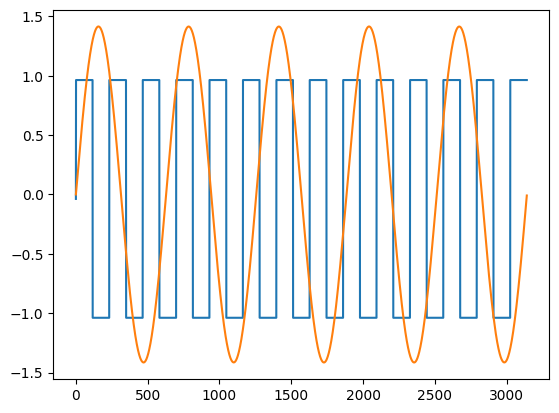

In [45]:
Y = np.matmul(W,Z)
plt.plot(Y[0])
plt.plot(Y[1])
plt.show()

## **以下を実行**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random

def ICA(datanum, X, datadim):
    
    X = np.array(X) 
    datasize, datanum = X.shape     # datasizeは時系列の数、datanumはデータ数
    
    # Xの各列ベクトルの平均を0にする
    X = X - np.mean(X, axis=0)
    X = X.T
    
    # 共分散行列を求める
    # 共分散行列VarSigmaは、以下の式で求める
    # VarSigma = E[x_j * x_j^T]
    VarSigma = np.zeros((datanum, datanum))
    for j in range(datasize):
        VarSigma += np.outer(X[:,j], X[:,j])    # np.outerは直積(ベクトルどうしのテンソル積)
    VarSigma /= datasize
    
    # 対称行列の直交行列による対角化
    def Eigenvalue_decomp(A):
        # A: 対称行列
        # return: 対角化された対称行列D, 直交行列E
        # A = EDE^T
        # D: 対角行列
        # E: 直交行列
        la, U = np.linalg.eig(A)
        D = np.diag(la)
        E, _ = np.linalg.qr(U)
        return D, E
    
    # 共分散行列を直交行列Eにより対角化する
    # D: 対角行列
    # E: 直交行列
    D, E = Eigenvalue_decomp(VarSigma)
    
    # V = E * D^(-1/2) * E^T    を求める
    D_sub = np.linalg.inv(np.power(D, 0.5))
    V = np.matmul(np.matmul(E, D_sub), E.T)

    # 列ベクトルがz_jになる行列Zを求める(このZを介してXを独立な信号源に変換する)
    Z = np.matmul(V, X)
    
    flag2 = 0
    while flag2 == 0:
        # 信号源は、観測データの線形結合で表されると仮定し、Zから独立な信号源への変換行列Wを求める
        # 適当な行列Wを用意し、初期化する
        # 行列のサイズは、datadim×datanumとする
        W = []
        for j in range(datadim):
            W.append([random.random() for i in range(datanum)])
        W = np.array(W)
        
        # Wを行ベクトル(datadim次元)ごとに正規化する
        for i in range(datadim):
            W[i] /= np.linalg.norm(W[i])
        print("W:",W)
            
        # Wの行ベクトルを更新する(第i行ベクトルを更新する)
        # Wの第i行ベクトルを転置したもの(N次元列ベクトル)をwt_iとし、以下の式で更新する
        # wt_i = E[z_j * (wt_i^T * z_j)^3] - 3 * wt_i
        # 更新したwt_iを正規化する
        # 変化している場合は、更新を続ける
        for i in range(datadim):
            wt_i = W[i]
            while True:
                wt_i_old = wt_i
                wt_i = np.zeros(datanum)
                for j in range(datasize):
                    wt_i += Z[:,j] * np.power(np.dot(wt_i_old, Z[:,j]), 3)
                wt_i /= datasize
                wt_i -= 3 * wt_i_old
                wt_i /= np.linalg.norm(wt_i)
                # 振動するのを防ぐために、wt_iの第1成分を正にする
                if wt_i[0] < 0:
                    wt_i *= -1
                # 更新幅が小さくなったら終了
                if np.linalg.norm(wt_i - wt_i_old) < 0.00001:
                    break
            # 初期値次第では、同じ行ベクトルが複数生成される場合があるので、それを防ぐ
            if i > 0:
                flag = 0
                # すでに生成された行ベクトルと同じものが生成された場合は、再生成する
                for j in range(i):
                    if np.linalg.norm(wt_i - W[j]) < 0.5:
                        W[i] = [random.random() for i in range(datanum)]
                        # 正規化する
                        W[i] /= np.linalg.norm(W[i])
                        i -= 1
                        flag = 1
                        break
                if flag == 0:
                    W[i] = wt_i
            else:
                W[i] = wt_i
        print("W:", W)
        
        # ZをWで変換し、独立な信号源Yを求める
        Y = np.matmul(W,Z)
        
        # Yの二つの行ベクトルの相関係数を求め、大きい場合は独立な信号源として扱わない
        flag2 = 1
        cormatrix = np.corrcoef(Y)
        for i in range(datadim):
            for j in range(i+1, datadim):
                # print("Y[",i,"]とY[",j,"]の相関係数:",np.corrcoef(Y[i], Y[j]))
                if cormatrix[i][j]>0.5:
                    flag2 = 0
                    break
            if flag2 == 0:
                break
    
    
    # 図示する
    plt.plot(Y[0])
    plt.plot(Y[1])
    plt.show()
    
    return Y

W: [[0.31036431 0.95061769]
 [0.70758539 0.70662785]]
W: [[0.56011828 0.82841265]
 [0.01756805 0.99984567]]
W: [[0.08381505 0.99648133]
 [0.17377659 0.9847851 ]]
W: [[0.56011826 0.82841266]
 [0.94145432 0.33714056]]
W: [[0.91451186 0.40455909]
 [0.08824972 0.99609838]]
W: [[0.5601182  0.8284127 ]
 [0.81837884 0.5746791 ]]
W: [[0.85951775 0.5111059 ]
 [0.39924847 0.91684276]]
W: [[0.56011824 0.82841267]
 [0.75030918 0.66108709]]
W: [[0.93254287 0.36105927]
 [0.93705501 0.34918177]]
W: [[0.5601183  0.82841264]
 [0.18511195 0.98271744]]
W: [[0.48594066 0.87399181]
 [0.03718524 0.99930839]]
W: [[0.56011826 0.82841266]
 [0.93778749 0.34720977]]
W: [[0.2838653  0.95886417]
 [0.87025929 0.49259391]]
W: [[0.56011829 0.82841264]
 [0.6364897  0.7712852 ]]
W: [[0.73050759 0.68290458]
 [0.32960529 0.94411882]]
W: [[0.56011823 0.82841268]
 [0.64465948 0.76446985]]
W: [[0.61796574 0.78620503]
 [0.9893497  0.14555815]]
W: [[ 0.56011821  0.8284127 ]
 [ 0.82860318 -0.55983638]]


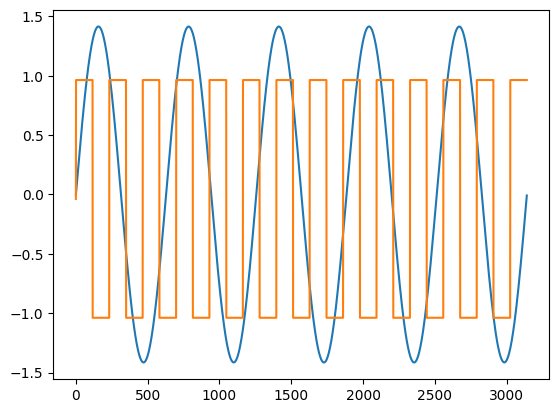

In [18]:
f1 = open('data/dat1.txt')
f2 = open('data/dat2.txt')
X = []
while True:
    line1 = f1.readline()
    line2 = f2.readline()
    if not line1:
        break
    # print(line1, end='')
    # print(line2, end='')
    X.append([float(line1), float(line2)])
    
Y = ICA(2, X, 2)